In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
articles = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

## ACTICLES

In [3]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [5]:
numeric_cols = articles.select_dtypes(include='int64')
negative_ones_count = (numeric_cols == -1).sum()

print(negative_ones_count)


article_id                      0
product_code                    0
product_type_no               121
graphical_appearance_no        52
colour_group_code              28
perceived_colour_value_id      28
perceived_colour_master_id    685
department_no                   0
index_group_no                  0
section_no                      0
garment_group_no                0
dtype: int64


* Có thể thấy dữ liệu không có giá trị Nan. Tuy nhiên lại chứa giá trị -1 nhưng phần trăm trên tổng data ít
* Ngoài cột product_type_no những cột có giá trị -1 khác có thể không hữu dụng hoặc có thể dựa vào những trường khác
* Chỉ làm sạch cột product_type_no
* Có những giá trị cùng product_code nhưng khác product_name. Có thể là sai xót khi nhập liệu

In [7]:
# Làm sạch product_name
def clean_name(name):
    name = str(name).lower().strip()  
    name = name.replace('(1)', '')  
    name = ' '.join(name.split())  
    return name
    
articles['cleaned_name'] = articles['prod_name'].apply(clean_name)


In [8]:
standard_names = articles.groupby('product_code')['cleaned_name'] \
                            .agg(lambda x: x.value_counts().idxmax()) \
                            .reset_index().rename(columns={'cleaned_name': 'standard_name'})


In [9]:
articles = articles.merge(standard_names, on='product_code', how='left')
articles['prod_name'] = articles['standard_name']

articles.drop(columns=['cleaned_name', 'standard_name'], inplace=True)


In [10]:
# Fill giá trị -1 của trường product_type_no dựa trên trường product_no,prod_name
valid_reference = articles[
    (articles['product_type_no'] != -1) &
    (articles['product_type_name'].str.lower() != 'unknown') &
    (articles['product_group_name'].str.lower() != 'unknown')
].drop_duplicates(subset=['product_code'])

# Chỉ giữ các cột cần thiết
valid_reference = valid_reference[['product_code', 'product_type_no', 'product_type_name', 'product_group_name']]


In [11]:
# Gộp dữ liệu gốc với dữ liệu hợp lệ theo product_code
articles = articles.merge(valid_reference, on='product_code', how='left', suffixes=('', '_ref'))


In [12]:
# Với product_type_no
articles['product_type_no'] = articles.apply(
    lambda row: row['product_type_no_ref'] if row['product_type_no'] == -1 else row['product_type_no'],
    axis=1
)

# Với product_type_name
articles['product_type_name'] = articles.apply(
    lambda row: row['product_type_name_ref'] if row['product_type_name'].lower() == 'unknown' else row['product_type_name'],
    axis=1
)

# Với product_group_name
articles['product_group_name'] = articles.apply(
    lambda row: row['product_group_name_ref'] if row['product_group_name'].lower() == 'unknown' else row['product_group_name'],
    axis=1
)


In [13]:
# Xóa cột tham chiếu
articles.drop(columns=['product_type_no_ref', 'product_type_name_ref', 'product_group_name_ref'], inplace=True)

# Và chuyển product_type_no về kiểu int
articles['product_type_no'] = articles['product_type_no'].astype('Int64')  # hoặc int nếu chắc chắn không có NaN


In [14]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,strap top,253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,op t-shirt (idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,op t-shirt (idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [15]:
type_counts = articles['product_type_name'].value_counts()
type_counts

product_type_name
Trousers         11175
Dress            10366
Sweater           9302
T-shirt           7914
Top               4155
                 ...  
Keychain             1
Cushion              1
Blanket              1
Bra extender         1
Clothing mist        1
Name: count, Length: 130, dtype: int64

### ACTICLES VISUALIZATION

****Q1: LOẠI SẢN PHẨM NÀO ĐƯỢC SẢN XUẤT NHIỀU NHẤT****

In [16]:
type_percent = (type_counts / type_counts.sum() * 100).round(2)

In [17]:
top10 = type_percent.head(10)

In [21]:
import matplotlib.cm as cm

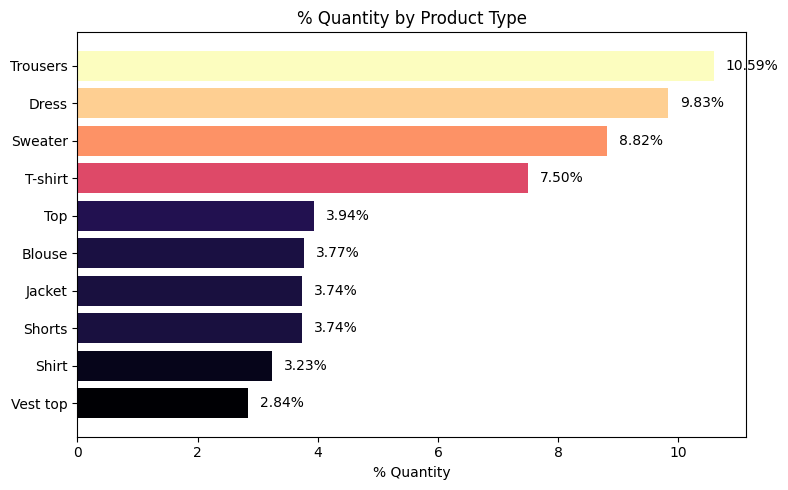

In [22]:
labels = top10.index[::-1]
values = top10.values[::-1]
norm = plt.Normalize(values.min(), values.max())
colors = cm.magma(norm(values)) 
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
bars = plt.barh(top10.index[::-1], top10.values[::-1], color=colors)

# Thêm giá trị phần trăm lên đầu cột
for i, v in enumerate(top10.values[::-1]):
    plt.text(v + 0.2, i, f'{v:.2f}%', va='center')

plt.xlabel('% Quantity')
plt.title('% Quantity by Product Type')
plt.tight_layout()
plt.show()


**Q2:NHỮNG MẶT HÀNG NÀO CÓ GIÁ TRỊ CAO NHẤT**

In [26]:
# Giả sử df_t là transactions có article_id, price
# df_a là articles có article_id, prod_name

# Kết hợp bảng để có tên sản phẩm
merged = transactions.merge(articles[['article_id', 'prod_name']], on='article_id', how='left')

# Tìm giá cao nhất cho mỗi article_id
max_price = merged.groupby(['article_id', 'prod_name'])['price'].max().reset_index()

# Lấy top 10 sản phẩm theo giá
top10_price = max_price.sort_values(by='price', ascending=False).head(10)

print(top10_price)


        article_id                 prod_name     price
50768    697511001     pe linda leather coat  0.591525
89491    839478001    pq susan leather tunic  0.506780
37363    653551001      benji leather jacket  0.506780
79226    797432001     cement leather jacket  0.506780
82848    810872001     pq agda leather dress  0.506780
25566    613539001         ce ivy lace dress  0.506780
103118   916300001     pq olga leather dress  0.506780
56087    713219001  lemon shearling jacket 1  0.506780
103119   916300002     pq olga leather dress  0.506780
81307    805760001    lemon shearling jacket  0.506780


In [25]:
articles.groupby(['index_group_name', 'index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

* Ladiswear chiếm một phần đáng kể. Sport chiếm một phần ít

## CUSTOMERS

In [27]:
customers.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [28]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


* Một lượng lớn giá trị NaN trong trường FN, Active. Tuy nhiên không hữu dụng khi phân tích nên không thay đổi
* Hơn 1,1% giá trị tuổi bị thiếu không quá ảnh hưởng
* Nhìn chung data sạch 

### CUSTOMERS VISUALIZATION

**Q1: Khách hàng chủ yếu thuộc độ tuổi nào ?**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


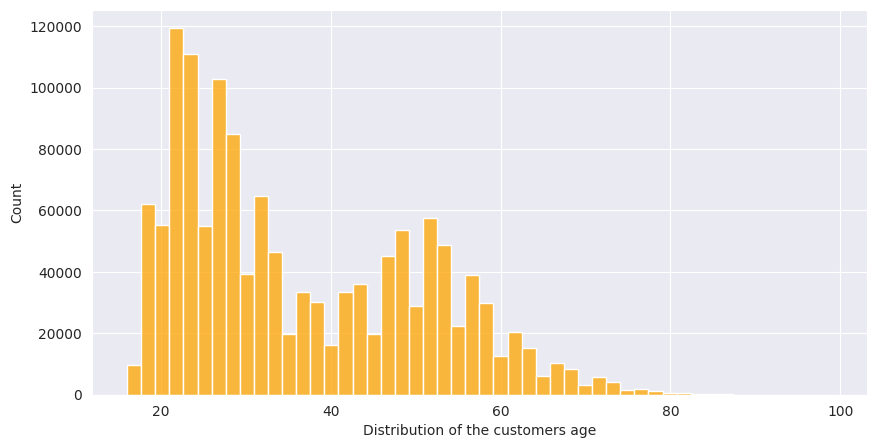

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

**Q2: Nhóm tuổi nào có lượng đơn hàng nhiều nhất? Nhóm có nhiều đơn hàng nhất có đem lại nhiều doanh thu nhất cho công ty hay không ?**

In [30]:
# Tính tổng tiền chi tiêu của mỗi khách hàng.
df_cust_prices = transactions[["customer_id", "price"]].groupby("customer_id").sum()
df_cust_prices.head()

,price
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.648983
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2.601932
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.704780
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.060983
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.469695


In [31]:
# Tính số lượng món hàng đã mua của mỗi khách hàng
df_cust_qty = transactions[["customer_id", "article_id"]].groupby("customer_id").count()
df_cust_qty.head()

,article_id
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,21
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,86
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,13


In [32]:
# Kết hợp tổng tiền chi tiêu và số lượng sản phẩm mua thành một bảng.
cust_qty_price = pd.merge(df_cust_prices, df_cust_qty, on='customer_id', how='inner')
cust_qty_price.head()

,price,article_id
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.648983,21
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2.601932,86
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.704780,18
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.060983,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.469695,13


In [33]:
# Ghép thêm thông tin chi tiết về khách hàng vào bảng đã tổng hợp.
cust_details = pd.merge(cust_qty_price, customers, on='customer_id', how='inner')
cust_details.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,customer_id,price,article_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.648983,21,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2.601932,86,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.704780,18,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,2,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.469695,13,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [34]:
# Gán nhóm tuổi cho từng khách hàng để phân tích dễ hơn.
cust_details['age_groups'] = pd.cut(cust_details['age'], bins=[16, 20, 30, 40,50, 60, 70, float('Inf')], labels=['16-20', '20-30','30-40','40-50','50-60','60-70' , '70+'])

/tmp/ipykernel_35/1908619377.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sns.barplot(x="age_groups", y="Purchased Quantity(%)", data=cust_details.groupby("age_groups")["article_id"].sum() \
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


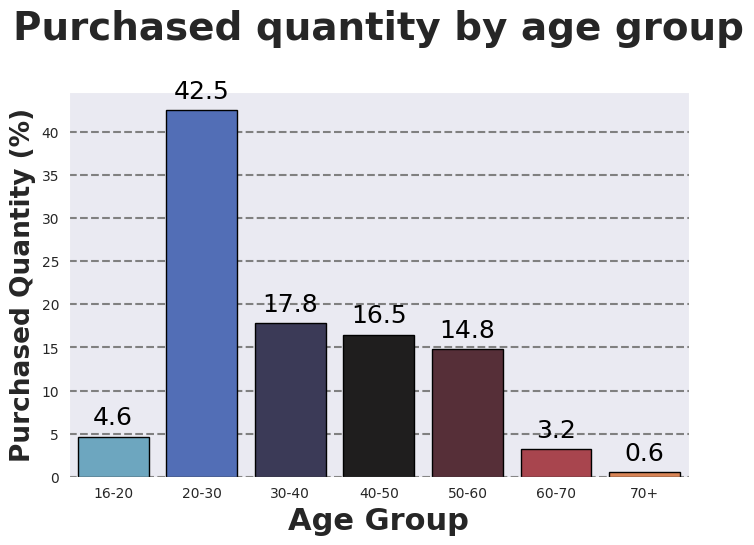

In [35]:
plt.figure(figsize=(8,5))
plt.title("Purchased quantity by age group\n", fontweight="bold", size=28)
g = sns.barplot(x="age_groups", y="Purchased Quantity(%)", data=cust_details.groupby("age_groups")["article_id"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('Purchased Quantity(%)').reset_index(), palette="icefire", edgecolor="black")
plt.xlabel("Age Group",fontweight="bold", size=22)
plt.ylabel("Purchased Quantity (%)",fontweight="bold", size=19)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=18, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

* Nhóm tuổi 20-30 là nhóm có lượng mua hàng nhiều nhất

/tmp/ipykernel_35/2928386704.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = sns.barplot(x="age_groups", y="earning(%)", data=cust_details.groupby("age_groups")["price"].sum() \
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


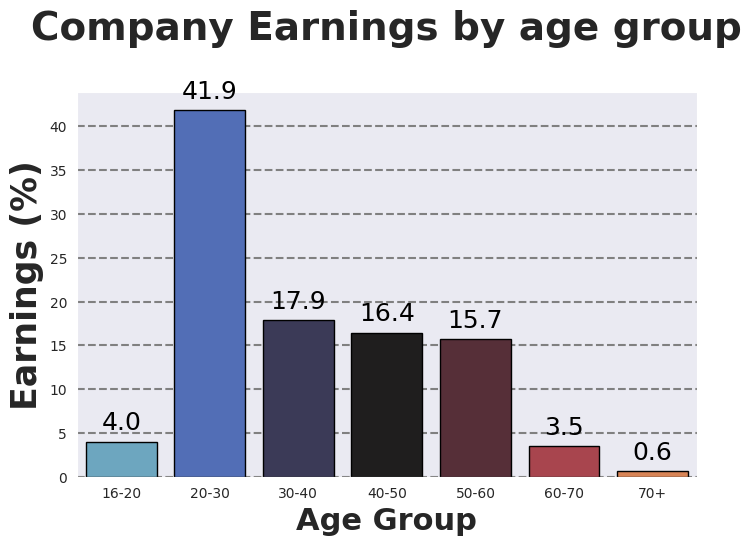

In [36]:
plt.figure(figsize=(8,5))
plt.title("Company Earnings by age group\n", fontweight="bold", size=28)
g = sns.barplot(x="age_groups", y="earning(%)", data=cust_details.groupby("age_groups")["price"].sum() \
            .transform(lambda x: (x / x.sum() * 100)).rename('earning(%)').reset_index(), palette="icefire",edgecolor="black")
plt.xlabel("Age Group",fontweight="bold", size=22)
plt.ylabel("Earnings (%)",fontweight="bold", size=25)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=18, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()

* *Nhóm 20-30 cũng là nhóm đem lại doanh thu nhiều nhất cho công ty*

**Q3: Số lượng đơn hàng có chênh lệch đối với khách hàng hay nhận tin và không hay nhận tin hay không?**

In [38]:
df_qty_by_age_news = (
    cust_details
    .groupby(['age_groups', 'fashion_news_frequency'])['article_id']
    .count()
    .reset_index()
    .rename(columns={'article_id': 'purchased_qty'})
)
df_qty_by_age_news = df_qty_by_age_news[df_qty_by_age_news['fashion_news_frequency'].isin(['Regularly', 'NONE'])]
df_qty_by_age_news['pct'] = df_qty_by_age_news.groupby('age_groups')['purchased_qty'].transform(lambda x: (x / x.sum()) * 100)

/tmp/ipykernel_35/3139605291.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_groups', 'fashion_news_frequency'])['article_id']
/tmp/ipykernel_35/3139605291.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_qty_by_age_news['pct'] = df_qty_by_age_news.groupby('age_groups')['purchased_qty'].transform(lambda x: (x / x.sum()) * 100)


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


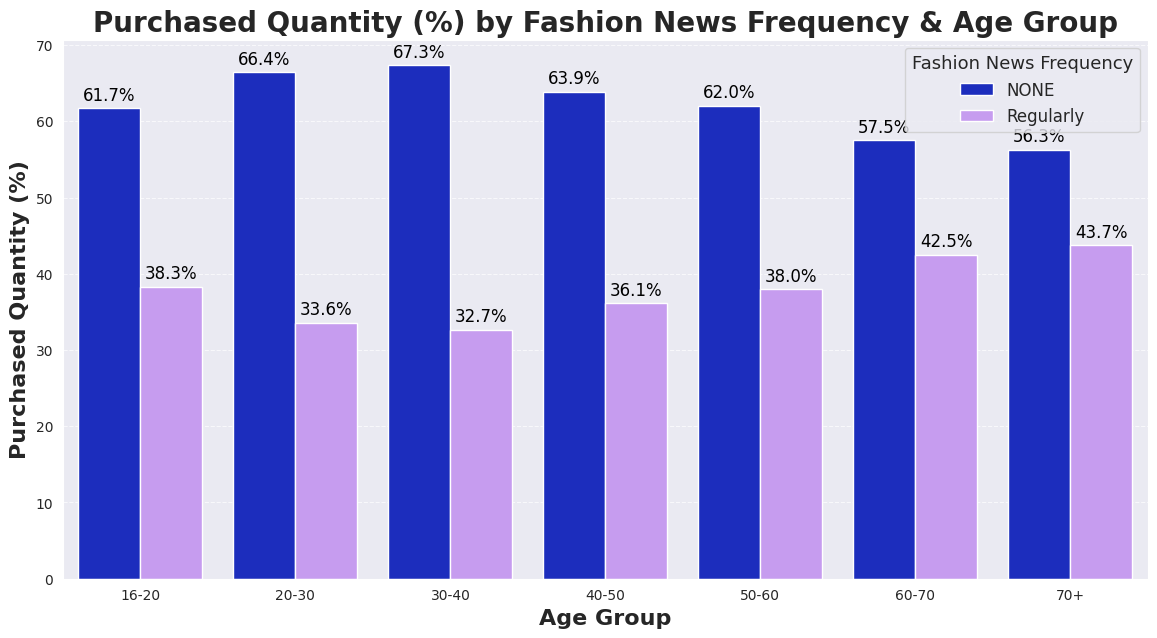

In [45]:
plt.figure(figsize=(14, 7))
g = sns.barplot(
    data=df_qty_by_age_news,
    x='age_groups',
    y='pct',
    hue='fashion_news_frequency',
    palette={'Regularly': '#C68EFD', 'NONE': '#0118D8'}
)

plt.title("Purchased Quantity (%) by Fashion News Frequency & Age Group", fontsize=20, fontweight='bold')
plt.xlabel("Age Group", fontsize=16, fontweight='bold')
plt.ylabel("Purchased Quantity (%)", fontsize=16, fontweight='bold')
plt.legend(title='Fashion News Frequency', fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ Thêm số % trên từng cột
for container in g.containers:
    g.bar_label(container, fmt='%.1f%%', fontsize=12, padding=3, color='black')

plt.show()

* Có thể thấy lượng đơn hàng đến chủ yếu từ khách hàng không đăng kí nhận tin từ nhãn hàng
* Có thể họ có xu hướng mua vì nhu cầu, sở thích chứ không chỉ vì những chương trình giảm giá,...

## TRANSACTIONS

In [48]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['day_of_week'] = transactions['t_dat'].dt.weekday + 1


In [50]:
# Đếm số lượt mua hàng theo từng ngày trong tuần
day_counts = transactions['day_of_week'].value_counts().sort_index()


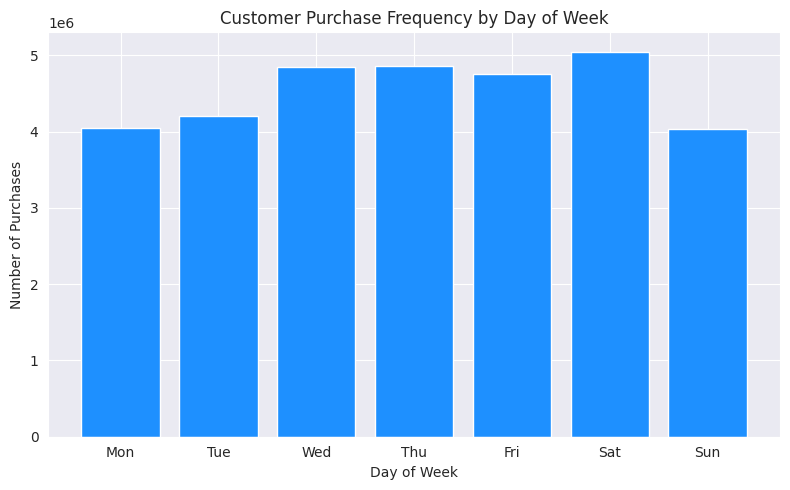

In [51]:
plt.figure(figsize=(8, 5))
bars = plt.bar(day_counts.index, day_counts.values, color='dodgerblue')

# Thêm nhãn
plt.xticks(ticks=range(1, 8), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Purchases')
plt.title('Customer Purchase Frequency by Day of Week')
plt.tight_layout()
plt.show()


* Lượng khách hàng tăng trong khoảng giữa tuần cho đến cuối tuần và giảm mạnh vào Chủ Nhật. Điều này có thể đến từ việc một số đất nước cuối tuần họ sẽ đóng cửa các cửa hàng và đơn hàng sẽ chỉ đến từ online